# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid')

Let's generate our dataset and take a look on it.

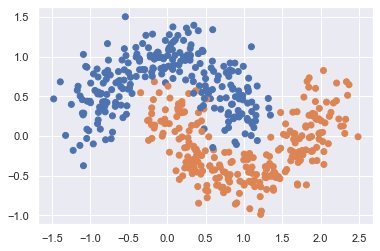

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], 
            c=[sns.color_palette()[i] for i in moons_labels])
plt.show()

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

As expected from these algorythms, we got two almost identical straight lines as a border between classes, certainly not the best possible quality, nothing interesting.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

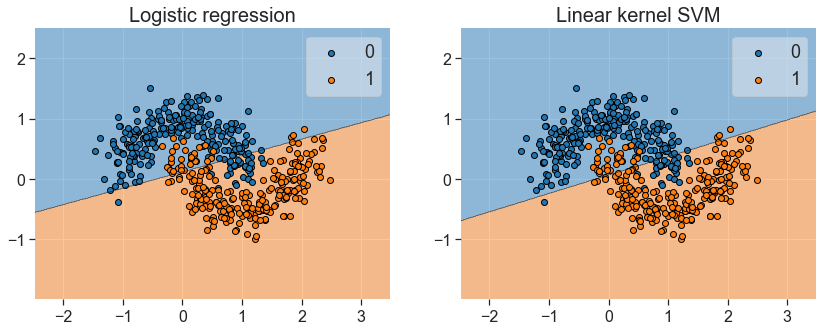

F1-scores:
  Logistic regression:  0.8599910394265233
  Linear kernel SVM:  0.8619861986198618

Accuracies:
  Logistic regression:  0.86
  Linear kernel SVM:  0.862


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score

from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(C=10, tol=0.0001, max_iter=1000) # add some params
svm = SVC(C=10, kernel='linear', tol=0.0001) # here too

preds = []

def plot_decisions(X, y, clf, ax=None, title=None, s=None, alpha=None):
    clf.fit(X, y)
    if ax is not None:
        plot_decision_regions(X=X, y=y, clf=clf, ax=ax,
                             markers='ooooooo', 
                              scatter_kwargs={'s':s, 'alpha':alpha})
        ax.set_title(title, fontsize=20)
        ax.legend(fontsize=18, framealpha=0.5, loc='upper right')
        ax.tick_params(axis='both', labelsize=16)
    else:
        plot_decision_regions(X=X, y=y, clf=clf, ax=ax,
                             markers='ooooooo', 
                              scatter_kwargs={'s':s, 'alpha':alpha})
        plt.title(title, fontsize=20)
        plt.legend(fontsize=18, framealpha=0.5, loc='upper right')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for ax, clf, title in zip(axes, [lr, svm], ['Logistic regression', 
                                           'Linear kernel SVM']):
    plot_decisions(X=moons_points, y=moons_labels, clf=clf, 
                   ax=ax, title=title)
    preds.append(clf.predict(moons_points))

plt.show()

def print_metrics(preds, true, labels):
    if type(preds) is list:
        print('F1-scores:')
        for i in range(len(preds)):
            print(f'  {labels[i]}:  {f1_score(true, preds[i], average="macro")}')
        print('\nAccuracies:')
        for i in range(len(preds)):
            print(f'  {labels[i]}:  {accuracy_score(true, preds[i])}')
            
    else:
        print(f'F1-score:\n  {labels}:  {f1_score(true, preds, average="macro")}')
        print(f'\nAccuracy:\n  {labels}:  {accuracy_score(true, preds)}')
        
print_metrics(preds, moons_labels, ['Logistic regression', 'Linear kernel SVM'])

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?

Increased significantly for each one except sigmoid kernel. One with rbf-kernel seems unbeatable with reasonable algorythm.

* How did decision border changed for each kernel?

It became non-linear for each kernel, but it's difficult to specify its non-linearity by sight.

* What `degree` have you chosen and why?

5 according to CV (it's was just easier to copy-paste CV code from part 2 then write almost the same with cycles over the params learning on whole train sample)

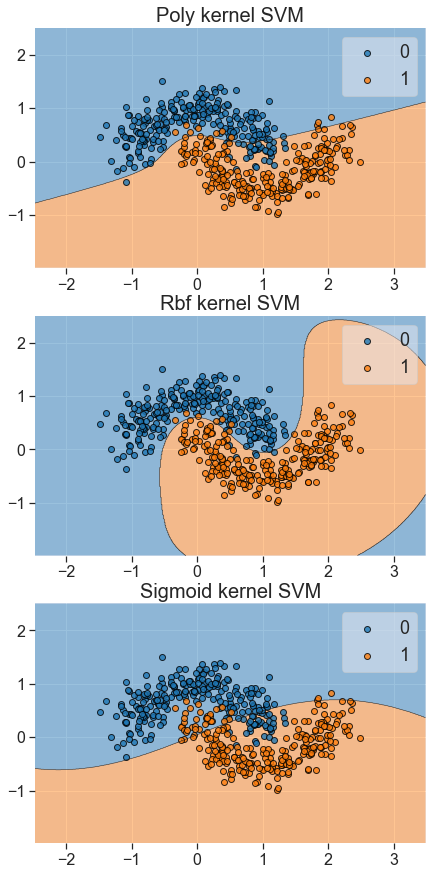

F1-scores:
  Poly kernel SVM:  0.9058006742266638
  Rbf kernel SVM:  0.9759996159938559
  Sigmoid kernel SVM:  0.841999367997472

Accuracies:
  Poly kernel SVM:  0.906
  Rbf kernel SVM:  0.976
  Sigmoid kernel SVM:  0.842

Parameters:
  poly C:  4.460822488323482
  poly gamma:  0.5
  poly degree:  3

  rbf C:  0.8931925551155666
  rbf gamma:  1

  sigmoid C:  1.3581986558531576
  sigmoid gamma:  0.1


In [4]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
import random

svm_poly = SVC(kernel='poly', tol=0.0001)
svm_rbf = SVC(kernel='rbf', tol=0.0001)
svm_sigmoid = SVC(kernel='sigmoid', tol=0.0001)

parameters_grid = {
    'C': random.sample(list(np.logspace(-1.5, 2.5, 10000)), 20),
    'degree': np.arange(1, 6),
    'gamma': [0.1, 0.5, 1, 5, 10]
}
ss = StratifiedShuffleSplit(n_splits=3, test_size=0.2)

clfs = [svm_poly, svm_rbf, svm_sigmoid]
titles = ['Poly kernel SVM', 'Rbf kernel SVM', 'Sigmoid kernel SVM']

for i in range(3):
    
    grid_search = GridSearchCV(estimator=clfs[i],
                               cv=ss,
                               param_grid=parameters_grid,
                               n_jobs=14,
                               scoring='f1')
    grid_search.fit(moons_points, moons_labels)
    clfs[i] = grid_search.best_estimator_

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 15))

preds = []

for ax, clf, title in zip(axes, clfs, titles):
    plot_decisions(X=moons_points, y=moons_labels, clf=clf, 
                   ax=ax, title=title)
    preds.append(clf.predict(moons_points))

plt.show()

print_metrics(preds, moons_labels, titles)
print(f"\nParameters:\n  poly C:  {clfs[0].get_params()['C']}\n  poly gamma:  {clfs[0].get_params()['gamma']}\n  poly degree:  {clfs[0].get_params()['degree']}\n\n  rbf C:  {clfs[1].get_params()['C']}\n  rbf gamma:  {clfs[1].get_params()['gamma']}\n\n  sigmoid C:  {clfs[2].get_params()['C']}\n  sigmoid gamma:  {clfs[2].get_params()['gamma']}")

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Compare SVM's results with this solution (quality, borders type)

Border resembles one got by rbf-kernel SVM, quality is also quite the same.

* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

Best one found on CV is 5, my first take while doing it by hand would be 3, (which shows very similar results), because data seems (by sight) separable by 3-rd degree polynomial. 

(Actually, setting higher than 3-rd degree just imperceptibly changes the quality, making calculation more complex on the other hand, so I would say that 3-rd degree is optimal for this data).

As I understood, PolynomialFeatures degree have nothing similar with Poly-kernel degree, so, despite we got the same value, we can't get much from comparing this numbers.

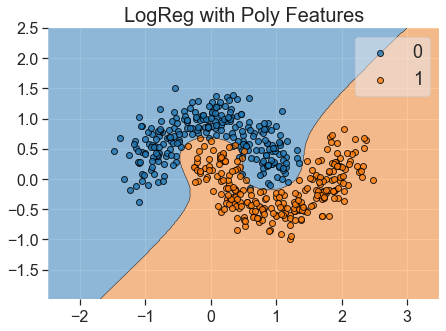

F1-score:
  LogReg with Poly Features:  0.981999927999712

Accuracy:
  LogReg with Poly Features:  0.982

Parameters:
  C:  83.02175681319748
  penalty:  none
  max_degree:  3


In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

parameters_grid = {
    'transformer__degree': np.arange(2, 15),
    'regressor__penalty': ['l2', 'l1', 'none'],
    'regressor__C': random.sample(list(np.logspace(0, 2, 100)), 50),
}

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

model = Pipeline([('transformer', PolynomialFeatures()),
                 ('regressor', LogisticRegression(tol=1e-4, max_iter=500))])

grid_search = GridSearchCV(estimator=model,
                          cv=ss,
                          param_grid=parameters_grid,
                          n_jobs=16,
                          scoring="f1")

grid_search.fit(moons_points, moons_labels)

plt.figure(figsize=(7,5))
plot_decisions(X=moons_points, y=moons_labels, clf=grid_search, 
               title='LogReg with Poly Features')
plt.show()

print_metrics(grid_search.predict(moons_points), moons_labels, labels='LogReg with Poly Features')

print(f"\nParameters:\n  C:  {grid_search.best_estimator_.get_params()['regressor__C']}\n  penalty:  {grid_search.best_estimator_.get_params()['regressor__penalty']}\n  max_degree:  {grid_search.best_estimator_.get_params()['transformer__degree']}")

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

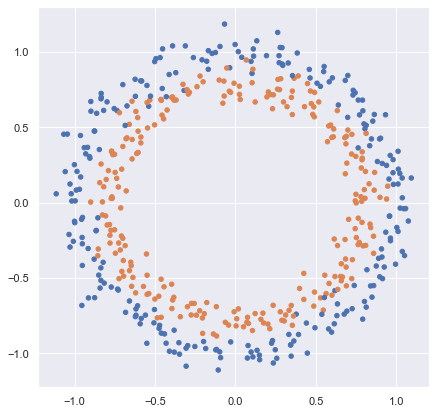

In [6]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(7, 7))
plt.scatter(circles_points[:, 0], circles_points[:, 1], s=20,
           c=[sns.color_palette()[i] for i in moons_labels])

And even more:

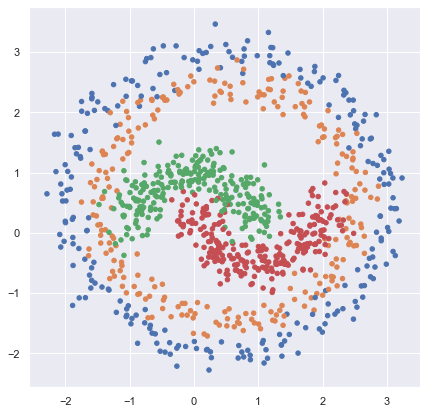

In [7]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(7, 7))
plt.scatter(points[:, 0], points[:, 1], s=20,
           c=[sns.color_palette()[i] for i in labels])
plt.show()

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

Well, RBF kernel SVM with PolyFeatures just works and works pretty alright (actually with no poly features, because best max_degree = 1). According to the plot, it's hard to imagine significantly better borders that do not simply surround each dot independently, which would definetely be an overfitting, that's why further ivestigations is not necessary, but...

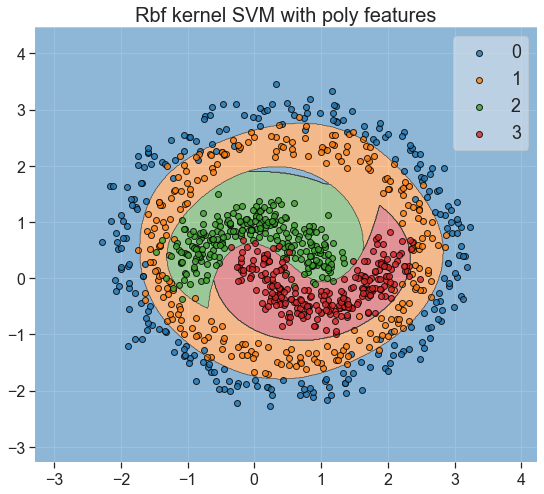

F1-score:
  Rbf kernel SVM with poly features:  0.9399909285097818

Accuracy:
  Rbf kernel SVM with poly features:  0.94

Parameters:
  C:  29.150530628251758
  gamma:  0.2782559402207124
  max_degree:  1


In [8]:
parameters_grid_ = {
    'transformer__degree': np.arange(1, 8),
    'SVM__C': np.logspace(0, 2.5, 100),
    'SVM__gamma': np.logspace(-1, 1, 10)
}

model_ = Pipeline([('transformer', PolynomialFeatures()),
                  ('SVM', SVC(kernel='rbf', tol=0.00001))])
ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

grid_search_ = GridSearchCV(estimator=model_,
                          cv=ss,
                          param_grid=parameters_grid_,
                          n_jobs=15,
                          scoring="accuracy")
grid_search_.fit(points, labels)

final_model = grid_search_.best_estimator_

final_model.fit(points, labels)

plt.figure(figsize=(9,8))
plot_decisions(X=points, y=labels, clf=final_model, 
               title='Rbf kernel SVM with poly features')
plt.show()

print_metrics(final_model.predict(points), labels, labels='Rbf kernel SVM with poly features')

print(f"\nParameters:\n  C:  {final_model.get_params()['SVM__C']}\n  gamma:  {final_model.get_params()['SVM__gamma']}\n  max_degree:  {final_model.get_params()['transformer__degree']}")

F1-score:
  Gradient Boosting:  0.98403884542362

Accuracy:
  Gradient Boosting:  0.984

Parameters:
  n_estimators:  15
  max_depth:  6


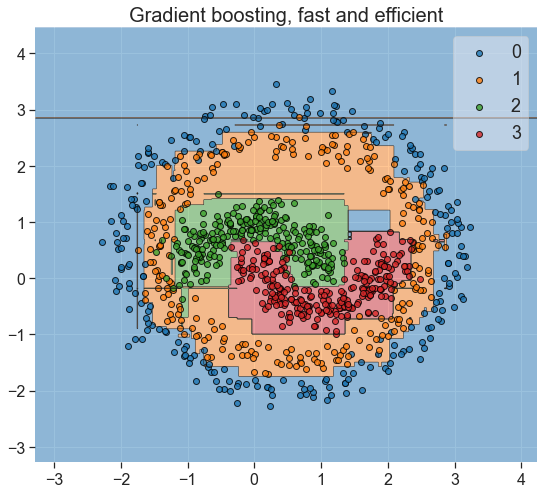

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators=15, max_depth=6)
GB.fit(points, labels)
plt.figure(figsize=(9,8))

plot_decisions(X=points, y=labels, clf=GB, 
               title="Gradient boosting, fast and efficient")

print_metrics(GB.predict(points), labels, labels='Gradient Boosting')
print(f"\nParameters:\n  n_estimators:  {GB.get_params()['n_estimators']}\n  max_depth:  {GB.get_params()['max_depth']}")

F1-score:
  Overfitted Gradient Boosting:  1.0

Accuracy:
  Overfitted Gradient Boosting:  1.0


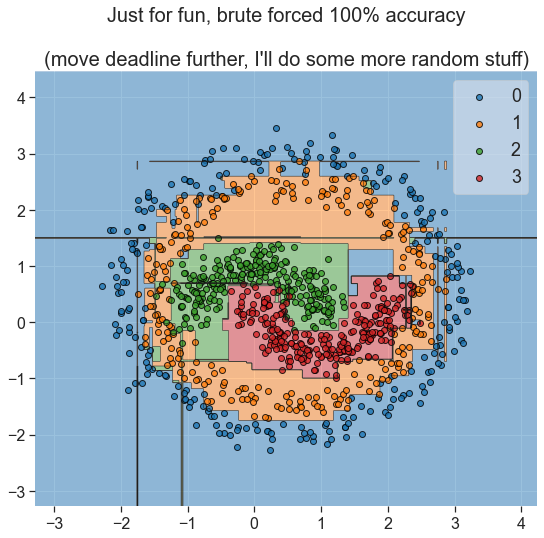

In [10]:
GB_ff = GradientBoostingClassifier(n_estimators=100, max_depth=20)
GB_ff.fit(points, labels)
plt.figure(figsize=(9,8))

plot_decisions(X=points, y=labels, clf=GB_ff,
               title="Just for fun, brute forced 100% accuracy\n\n(move deadline further, I'll do some more random stuff)")

print_metrics(GB_ff.predict(points), labels, labels='Overfitted Gradient Boosting')

F1-score:
  Deep Tree(max_depth=100):  1.0

Accuracy:
  Deep Tree(max_depth=100):  1.0


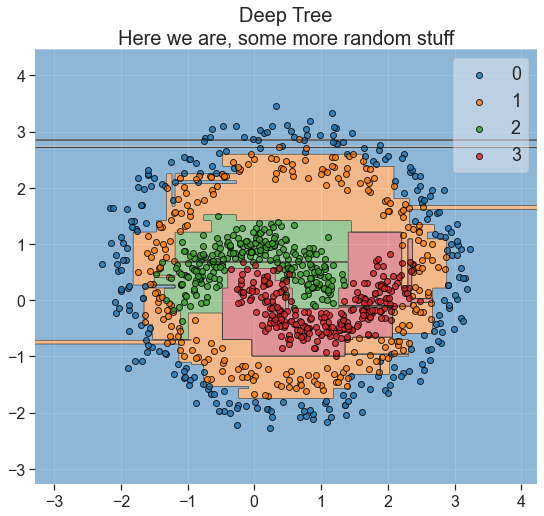

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=100)
tree.fit(points, labels)

plt.figure(figsize=(9,8))

plot_decisions(X=points, y=labels, clf=tree, 
               title="Deep Tree\nHere we are, some more random stuff")

print_metrics(tree.predict(points), labels, labels='Deep Tree(max_depth=100)')

### Now let's see why GB is just better:

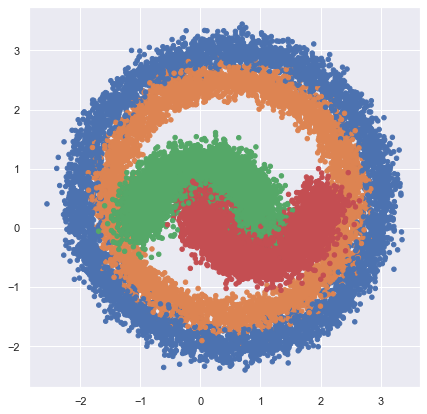

In [65]:
c_p, c_l = make_circles(n_samples=10000, noise=0.06, random_state=42)
m_p, m_l = make_moons(n_samples=10000, noise=0.2, random_state=42)

p = np.vstack((c_p*2.5 + 0.5, m_p))
l = np.hstack((c_l, m_l + 2))

plt.figure(figsize=(7, 7))
plt.scatter(p[:, 0], p[:, 1], s=20,
           c=[sns.color_palette()[i] for i in l])
plt.show()

F1-score:
  Gradient Boosting (20000 points):  0.9672283974438388

Accuracy:
  Gradient Boosting (20000 points):  0.9672

Parameters:
  n_estimators:  30
  max_depth:  7



Wall time: 8.87 s


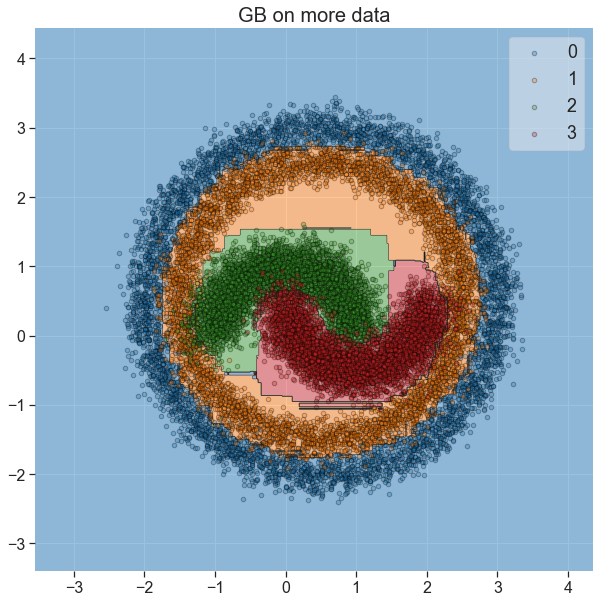

In [79]:
%%time
GB = GradientBoostingClassifier(n_estimators=30, max_depth=7)
GB.fit(p, l)
plt.figure(figsize=(10,10))

plot_decisions(X=p, y=l, clf=GB, title="GB on more data",
             s=20, alpha=0.3)

print_metrics(GB.predict(p), l, labels='Gradient Boosting (20000 points)')
print(f"\nParameters:\n  n_estimators:  {GB.get_params()['n_estimators']}\n  max_depth:  {GB.get_params()['max_depth']}")
print('\n\n')

F1-score:
  RBF-kernel SVM:  0.947484095379747

Accuracy:
  RBF-kernel SVM:  0.94745

Parameters:
  C:  0.893
  gamma:  1



Wall time: 2min 41s


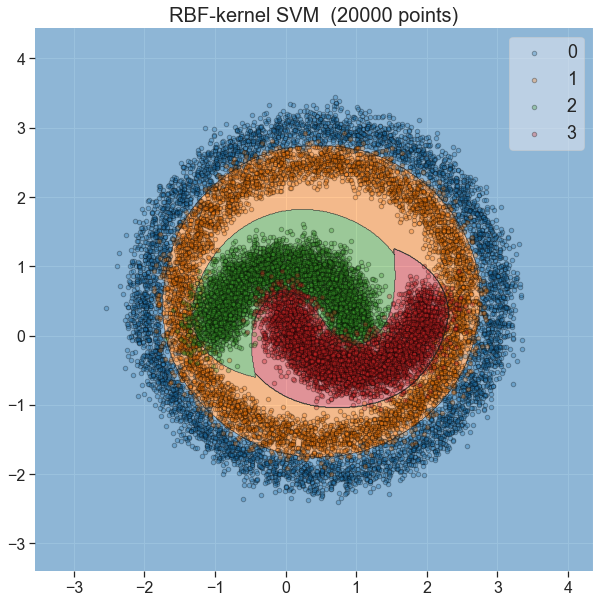

In [80]:
%%time
import random
svm = SVC(kernel='rbf', tol=0.0001, C=0.893, gamma=1)
svm.fit(p, l)
plt.figure(figsize=(10,10))

plot_decisions(X=p, y=l, clf=svm, title="RBF-kernel SVM  (20000 points)",
             s=20, alpha=0.3)

print_metrics(svm.predict(p), l, labels='RBF-kernel SVM')
print(f"\nParameters:\n  C:  {svm.get_params()['C']}\n  gamma:  {svm.get_params()['gamma']}")
print('\n\n')

#### As shown above, GB and RBG-kernel SVM performs quite similar, but GB requires approximately $\times$20 less time on 20000 objects, so it's obviously preferable to use over SVM on large datasets.